### Imports et initialisations

In [3]:
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras as keras
import random
import re
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

### Récupération des tweets

In [4]:
with open("dataset", "r") as file:
    lines = file.readlines()
    
#on travaille avec un échantillon de 5000 tweets
raw_sample = random.sample(lines, 5000)


### Nettoyage

In [5]:
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
stopwords = sorted(list(fr_stop))
stopwords.append('rt')

In [6]:
%%time
import spacy

#importer le vocabulaire français
nlp = spacy.load("fr_core_news_sm")

CPU times: user 1.01 s, sys: 64.9 ms, total: 1.07 s
Wall time: 1.11 s


In [7]:
%%time 

#transformer les tweets en objet spacy
docs = list(nlp.pipe(raw_sample))
#tokeniser et lemmatiser l'ensemble des tweets
""" -enlever la ponctuation,
    - enlever les espaces
    -enlever les email
    -enlever les urls
    -enlever les mots de moins de 3 caractères"""
first_clean_sample = [[token.lemma_.lower() for token in doc 
                               if not token.is_punct and not token.is_space and not token.like_url and not token.like_email and token.tag_!= 'Num'] for doc in docs]

CPU times: user 18.7 s, sys: 54.1 ms, total: 18.8 s
Wall time: 18.8 s


In [8]:
#vérifier le résultats
print(first_clean_sample[0])
raw_sample[0]

['rt', '@altair_conseil', 'l"#incendie', 'de', 'datacenter', 'ovh', 'de', 'strasbourg', 'faire', 'partir', 'en', 'fumée', 'un', 'partie', 'de', 'web', 'français', 'un', 'sinistre', 'qui', 'survi']


'RT @Altair_Conseil: L"#Incendie du #datacenter #OVH  de #Strasbourg fait partir en fumée une partie du Web français : un sinistre qui survi…\n'

In [59]:
#Deuxième passe de nettoyage
def clean(msg):
    clean_msg = []
    for word in msg:
        #Supprimer tout ce qui n'est pas des lettres
        clean_word = re.sub(r'\W', '', word)
        #Supprimer les chiffres
        clean_word = re.sub(r'\d', '', clean_word)
        if clean_word not in stopwords : 
            clean_msg.append(clean_word)
    return clean_msg

In [60]:
clean_sample = []

#Nettoyage des tweets
for msg in first_clean_sample:
    clean_sample.append(clean(msg))

In [61]:
#On a bien uniquement du texte
print(clean_sample[0])
print(raw_sample[0])

['altair_conseil', 'lincendie', 'datacenter', 'ovh', 'strasbourg', 'faire', 'partir', 'fumée', 'partie', 'web', 'français', 'sinistre', 'survi']
RT @Altair_Conseil: L"#Incendie du #datacenter #OVH  de #Strasbourg fait partir en fumée une partie du Web français : un sinistre qui survi…



In [62]:
for i, msg in enumerate(clean_sample):
    for word in msg:
        if word == "moi":
            print("msg {} : {}".format(i, word))

### Récupération des différents mots et de leur nombre d'occurences

Pour interpréter les résultats nous aurons besoin de connaître les mots les plus utilisés dans chaque cluster

Pour cela nous utilisons ces fonctions qui permettent d'obtenir une liste des mots du jeu de données (ou d'un sous ensemble comme ce sera le cas avec les clusters) triés par nombre d'occurences décroissant

In [65]:
#Création du dictionnaire de mots avec leur occurence
def create_wdict(lines):
    dico = {}
    for msg in lines:
        for mot in msg:
            if mot in dico: 
                dico[mot] += 1
            else:
                dico[mot] = 1
    return dico

#Création de la liste des mots triée par nombre d'occurences décroissant
def create_sorted_wlist(lines):
    dico = create_wdict(lines)
    wlist = [ (mot, dico[mot]) for mot in dico.keys()]
    return sorted(wlist, key = lambda mot: mot[1], reverse = True)

In [66]:
#dico = create_wdict(sample)

liste_mots_triee = create_sorted_wlist(clean_sample)

print("Il y a {} mots différents".format(len(liste_mots_triee)))
dict_len = len(liste_mots_triee) + 4
print("Les dix mots les plus utilisés sont :")
for mot in liste_mots_triee[1:10]:
    print(mot[0], end=' ')

Il y a 13463 mots différents
Les dix mots les plus utilisés sont :
c faire l aller j sale d n français 

### Encodage à l'aide d'un modèle word2vec pré entraîné

- Tout d'abord on charge le modèle en mémoire
- Puis on crée une fonction qui prend en entrée un tweet, traduit chaque mot en vecteur à l'aide du modèle et renvoie une moyenne de tous ces vecteurs. Cette moyenne sera l'encodage du tweet proprement dit.
- On utilise enfin cette fonction pour procéder à l'encodage du dataset

In [19]:
from gensim.models import KeyedVectors

In [20]:
%%time
#4 minutes environ sur ma machine

w2v = KeyedVectors.load_word2vec_format('frwiki_20180420_100d.txt', binary=False)

CPU times: user 4min 5s, sys: 2.32 s, total: 4min 7s
Wall time: 4min 7s


In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [22]:
tfidf = TfidfVectorizer()
tfidf.fit([' '.join(tweet) for tweet in clean_sample])

TfidfVectorizer()

In [23]:
tfidf.get_feature_names_out()

array(['__estrl', '_ahmedaz', '_ahmitofcb', ..., '𝚑𝚊ï𝚝𝚒𝚎𝚗𝚗𝚎', '𝚕𝚊',
       '𝚜𝚘𝚌𝚒𝚎𝚝é'], dtype=object)

In [24]:
max_idf = max(tfidf.idf_)
word2weight = {w : tfidf.idf_[i] for w, i in tfidf.vocabulary_.items()}

In [67]:
#encode un message
def encode(msg):
    return np.mean([w2v[word] for word in msg if word in w2v] or [np.zeros(100)], axis = 0)

def encode_with_tfidf(msg):
    vect_msg = []
    for word in msg:
        if word in w2v:
            if word in word2weight:
                vect_msg.append(w2v[word] * word2weight[word])
            else:
                vect_msg.append(w2v[word])
        vect_msg = np.zeros(100)
    return np.mean(vect_msg, axis = 0)

In [68]:
%%time
#encodage de l'échantillon pour créer le jeu de données
dataset_encoded = np.array([encode(msg) for msg in clean_sample])

CPU times: user 172 ms, sys: 4.09 ms, total: 176 ms
Wall time: 191 ms


### Visualisation du dataset

- On réalise une réduction de dimension afin de visualiser les données dans une grille en deux dimensions
- On utilise pour cela la méthode Truncated SVD qui est indiquée dans le cas de données éparses

In [70]:
%%time

pca = PCA(n_components=2)

#On crée une version en deux dimensions de notre jeu de données
two_dim_dataset = pca.fit_transform(dataset_encoded)

CPU times: user 677 ms, sys: 789 ms, total: 1.47 s
Wall time: 231 ms


In [71]:
#On utilise la matrice transposée de notre jeu de données pour pouvoir visualiser les données
b = two_dim_dataset.T

#Taille des figures
plt.rcParams["figure.figsize"] = (10,10)

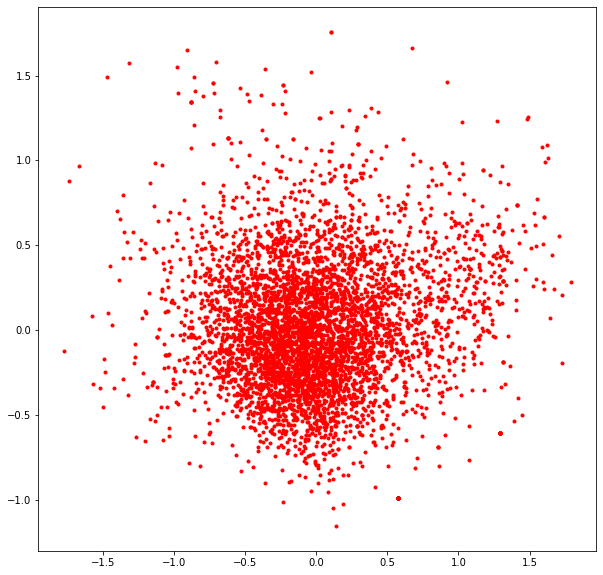

In [72]:
#Affichage des données
plt.plot(b[0], b[1], 'r.')
plt.show()

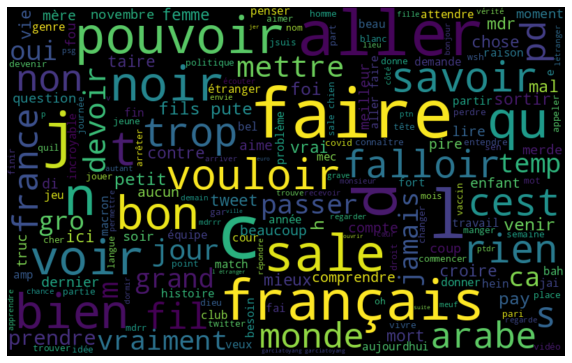

In [73]:
from wordcloud import WordCloud
all_words = ' '.join([" ".join(text) for text in clean_sample])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Fonctions pour la visualisation des clusters

Les algorithmes de classification renvoient une liste de la taille de notre dataset. Chaque élément de cette liste correspond au numéro de cluster auquel le message du même indice de notre jeu de données est associé.

Pour interpréter les résultats on a besoin de connaître les messages de chaque clusters on définit donc quelques fonctions qui vont nous permettre de manipuler les données :

- Une fonction qui construit un dictionnaire qui a chaque cluster associe la liste des indices des messages correspondants
- Une fonction qui construit la liste des mots et la liste des messages de chaque cluster.
- Une fonction qui affiche le nombre de messages pour chaque cluster
- Une fonction qui affiche pour chaque cluster la liste des n mots les plus utilisés
- Une fonction qui affiche un échantillon de messages pour chaque cluster
- Une fonction qui permet de visualiser les données catégorisées
- Et une fonction qui fait tout ça à la fois !

In [75]:
#Construire le dictionnaire des résultats qui à chaque cluster associe la liste indices des messages correspondants

def build_res_dict(pred):
    res = {}
    for i, lab in enumerate(pred): 
        if lab in res:
            res[lab].append(i)
        else:
            res[lab] = [i]
    return res
    
#construire la liste des mots et la liste des messages de chaque cluster
#utilise les variables globales clean_sample et raw_sample
def create_word_and_msg_lists(res):
    wlists = []
    mlists = []
    #parcourt les clés dans l'ordre croissant
    for i in sorted(res):
        idx_list = []
        msg_list = []
        raw_msg_list = []
        for n in res[i]: idx_list.append(n)
        for idx in idx_list: 
            msg_list.append(clean_sample[idx])
            raw_msg_list.append(raw_sample[idx])
        mlists.append(raw_msg_list)
        wlists.append(create_sorted_wlist(msg_list))
    return wlists, mlists

def print_clusters_info(n, res, wlists):
    for i, key in enumerate(sorted(res)):
        print("cluster {} : {} messages".format(key, len(res[key])))
        print("Les {} mots les plus fréquents :".format(n), end=" ")
        for tup in wlists[i][:n]:
            print(tup[0], end=' ')
        print('\n')
        
def print_sample(sample_size, res):
    for i, key in enumerate(sorted(res)):
        print("cluster {} (clé {})".format(i, key))
        try:
            sample = random.sample(res[key], sample_size)
        except ValueError:
            sample = res[key]
        for j in sample:
            print(raw_sample[j])
        print()

def plot_results(res):
    styles = ["r.", "b.", "k.", "g.", "y.", "c.", "m."]
    i = 0
    j = 0
    for key in res.keys():
        cluster_data = []
        for idx in res[key]:
            cluster_data.append(two_dim_dataset[idx])
        tcd = np.array(cluster_data).T
        if (j > 6): j = 0
        plt.plot(tcd[0], tcd[1], styles[j])
        i += 1
        j += 1
    plt.show()
    
def save_clusters_msg(mlists, method):
    if not os.path.exists("embedding_clusters/" + method): 
        os.mkdir("embedding_clusters/" + method)
    else :
        for file in os.scandir("embedding_clusters/" + method):
            os.remove(file.path)
    for i, mlist in enumerate(mlists):
        with open("embedding_clusters/{0}/{0}_cluster_{1}_msg.txt".format(method, i), "w") as f:
            for msg in mlist:
                f.write(msg)
                
def parse_results(pred, method):
    res = build_res_dict(pred)
    wlists, mlists = create_word_and_msg_lists(res)
    print_clusters_info(20, res, wlists)
    #print_most_used_words(20, wlists)
    #print_sample(3, res)
    plot_results(res)
    save_clusters_msg(mlists, method)
    

### Kmeans

In [74]:
n_clust = 15

In [34]:
%%time
km_model = KMeans(n_clusters=n_clust, random_state=0)
kmeans = km_model.fit(dataset_encoded)

CPU times: user 6.36 s, sys: 60.5 ms, total: 6.42 s
Wall time: 1.37 s


In [35]:
km_pred = kmeans.predict(dataset_encoded)

cluster 0 : 430 messages
Les 20 mots les plus fréquents :  faire pouvoir l c qu j n aller d devoir vouloir falloir voir s bien mettre t fils prendre 

cluster 1 : 98 messages
Les 20 mots les plus fréquents :  oui bah ok bonjour c voir merciii dis ptdr veux ouai aïe non j ahhhh troll notif ca ahah 

cluster 2 : 232 messages
Les 20 mots les plus fréquents :  c j sale mdr bon faire bien truc l cest pd oui gros d trop voir fou rien mec 

cluster 3 : 149 messages
Les 20 mots les plus fréquents :  c binance k lcrou manausdt ilysm fortuneday fabulou t sfft gourdeeeeeeeeeeeee test_geocode cea aba dbfc 𝑪𝒓𝒐𝒇𝒇𝒍𝒆 ptddddddrrrrr unjeuneissudel france_fr 

cluster 4 : 148 messages
Les 20 mots les plus fréquents :  club match sale faire l psg c j aller d qu monde équipe messi coupe jouer français joueur saison 

cluster 5 : 189 messages
Les 20 mots les plus fréquents :  fils pute mère l c d femme cest t sale bien qu homme gros frère grand fille mort aller 

cluster 6 : 107 messages
Les 20 mots les plu

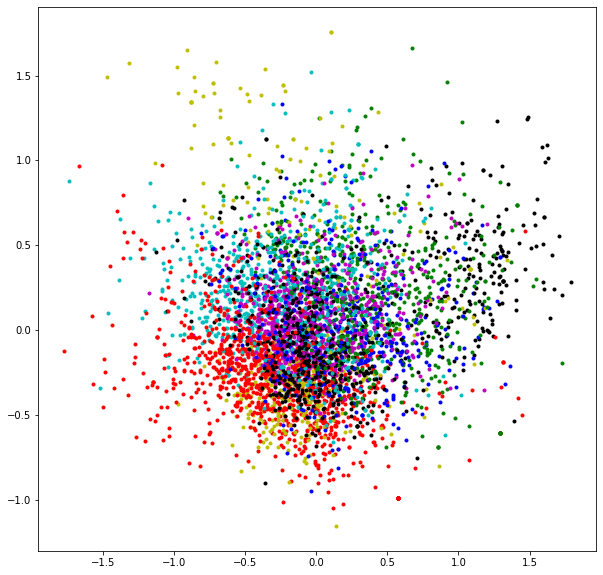

In [76]:
parse_results(km_pred, 'km')

In [37]:
centers = km_model.cluster_centers_

In [38]:
w2v.similar_by_vector(centers[9])

[('enamorarse', 0.8980391621589661),
 ('continuar', 0.8965420722961426),
 ('ENTITY/Shinji_Kakijima', 0.8900870680809021),
 ('ENTITY/Alex_Wheeler', 0.8827974796295166),
 ('contrário', 0.8818320035934448),
 ('ENTITY/Come_Again', 0.8796645402908325),
 ('목록', 0.8795148730278015),
 ('ENTITY/Owls', 0.8780438899993896),
 ('chatô', 0.8767799735069275),
 ('minchia', 0.8762690424919128)]

### SOM

In [225]:
from sklearn_som.som import SOM

In [226]:
%%time

som = SOM(m=6, n=6, dim=100)
som.fit(dataset_encoded)

CPU times: user 1 s, sys: 3.61 ms, total: 1.01 s
Wall time: 1.02 s


In [227]:
%%time

som_pred = som.predict(dataset_encoded)

CPU times: user 254 ms, sys: 49 µs, total: 254 ms
Wall time: 253 ms


cluster 0 : 188 messages
Les 20 mots les plus fréquents :   oui bah veux aller falloir voir trop bonjour sûr bon faire truc ok pd c est allez vraiment ouf ca 

cluster 1 : 148 messages
Les 20 mots les plus fréquents :   aime bien savoir vraiment rien voir jamais vrai faire trop mal oui vouloir dis croire pouvoir veux mieux chose 

cluster 2 : 156 messages
Les 20 mots les plus fréquents :   faire croire vouloir taire aller jamais savoir bien peur sale mettre trop mal envie falloir rien devoir raciste femme 

cluster 3 : 219 messages
Les 20 mots les plus fréquents :   aller faire falloir pouvoir mettre vouloir voir sale venir savoir bon prendre fils écouter perdre rien apprendre passer mieux 

cluster 4 : 223 messages
Les 20 mots les plus fréquents :   faire aller voir falloir prendre pouvoir    venir trop bien vouloir mettre vie temps vraiment jour passer bon monde 

cluster 5 : 107 messages
Les 20 mots les plus fréquents :   français faire arabe voir aller langue bien savoir venir    g

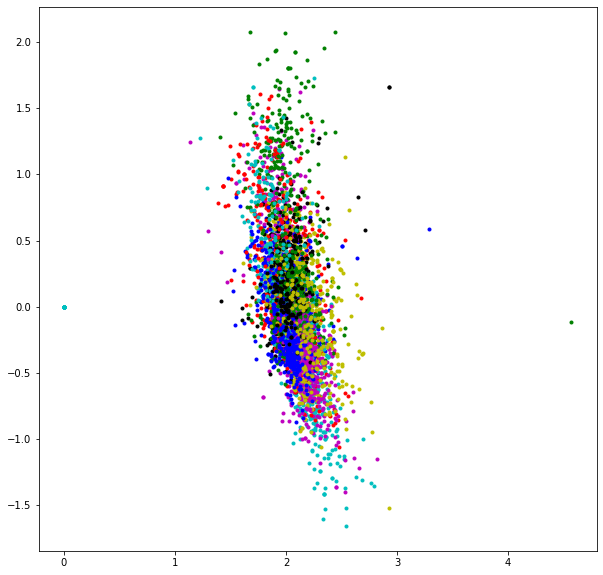

In [228]:
parse_results(som_pred, "som")

### DBSCAN

In [97]:
from sklearn.cluster import DBSCAN

In [98]:
%%time

dbscan_pred = DBSCAN().fit_predict(dataset_encoded)

CPU times: user 19min 7s, sys: 19.3 s, total: 19min 26s
Wall time: 19min 29s


cluster 0 : 4810 messages
cluster 1 : 7 messages
cluster 2 : 5 messages
cluster 3 : 8 messages
cluster 4 : 6 messages
cluster 5 : 6 messages
cluster 6 : 5 messages
cluster 7 : 5 messages
cluster 8 : 35 messages
cluster 9 : 7 messages
cluster 10 : 9 messages
cluster 11 : 6 messages
cluster 12 : 5 messages
cluster 13 : 18 messages
cluster 14 : 5 messages
cluster 15 : 5 messages
cluster 16 : 6 messages
cluster 17 : 6 messages
cluster 18 : 5 messages
cluster 19 : 5 messages
cluster 20 : 5 messages
cluster 21 : 6 messages
cluster 22 : 7 messages
cluster 23 : 10 messages
cluster 24 : 8 messages
Les 20 mots les plus fréquents du cluster 0 : a ça plus si quand fait faire tout cette être comme bien va trop tous quoi non là rt rien 

Les 20 mots les plus fréquents du cluster 1 : oui 

Les 20 mots les plus fréquents du cluster 2 : voilà 

Les 20 mots les plus fréquents du cluster 3 : merci 

Les 20 mots les plus fréquents du cluster 4 : yassification 

Les 20 mots les plus fréquents du cluster 5 

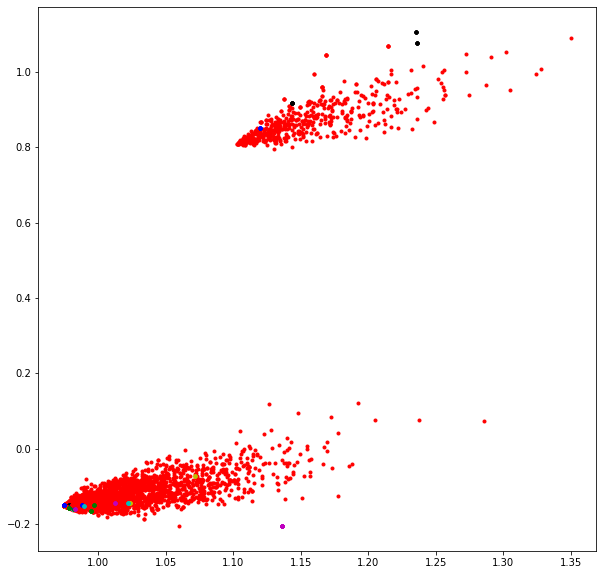

In [151]:
parse_results(dbscan_pred, "dbscan")

In [155]:
from sklearn.metrics import pairwise_distances

a = dataset_encoded[0]
b = dataset_encoded[1]

pairwise_distances(dataset_encoded)

array([[0.        , 5.38516481, 3.46410162, ..., 4.79583152, 3.87298335,
        3.60555128],
       [5.38516481, 0.        , 5.56776436, ..., 6.4807407 , 6.        ,
        5.83095189],
       [3.46410162, 5.56776436, 0.        , ..., 5.        , 4.35889894,
        4.12310563],
       ...,
       [4.79583152, 6.4807407 , 5.        , ..., 0.        , 5.47722558,
        5.29150262],
       [3.87298335, 6.        , 4.35889894, ..., 5.47722558, 0.        ,
        4.47213595],
       [3.60555128, 5.83095189, 4.12310563, ..., 5.29150262, 4.47213595,
        0.        ]])

### Affinity propagation

In [156]:
from sklearn.cluster import AffinityPropagation

In [157]:
%%time

AP_pred = AffinityPropagation().fit_predict(dataset_encoded)

CPU times: user 5min 8s, sys: 987 ms, total: 5min 9s
Wall time: 5min 9s


/home/victor/fidle/fidle-env/lib/python3.9/site-packages/sklearn/cluster/_affinity_propagation.py:250: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  warnings.warn(


cluster 0 : 5000 messages
Les 20 mots les plus fréquents du cluster 0 : a ça plus si quand tout faire fait cette être comme bien va trop non tous quoi merci rt là 

cluster 0 (clé -1)
M. Pokora si les actes ne l’avait pas manqués https://t.co/Q7U9upiEjc

Le programme des équipes du CBB jouant à domicile samedi prochain #cherbourgbasketball #cherbourg #basket #CBB #championnat #matchs #region https://t.co/44W849jlGG

C'est une de nos qualités quand on est Army😌😌 tmtc




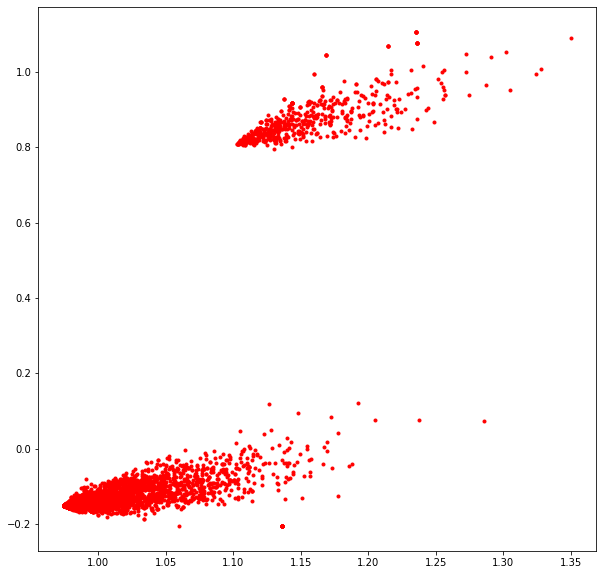

In [159]:
parse_results(AP_pred, "AP")